# Pixel level classification using Mulit Layer Perceptron

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sb
import warnings
import cv2

# for MLP 
import tensorflow as tf 

%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.figsize'] = [18, 16]
plt.rcParams['figure.dpi'] = 80
plt.rcParams['savefig.dpi'] = 80
plt.rcParams['font.size'] = 14
warnings.filterwarnings("ignore")

## Preprocessing 

In [2]:
# Load dataset
cwd_path = 'dataset/'
img = cv2.imread(cwd_path + 'frame170.jpg')
img_GT = cv2.imread(cwd_path + 'frame170.png')

In [3]:
def OneHotEncoder(y, labels):
    '''
    OnehotEncode the target whatever values in there 
    labels: label values in repetition within the matrix `y` 
    '''
    label = 0
    for l in labels:
        y[y == l] = label
        label += 1
    
    target = np.zeros((y.size, y.max()+1))
    target[np.arange(y.size), y] = 1
    return target

In [4]:
def CreateDataset(image, image_GT):
    '''
    Create dataset by separating channels and grayscaling the target(GroundTruth)
    OneHotEncode the target 
    '''
    # Seprate channels of original image, flatten then stack together
    img_B, img_G, img_R = image[:,:,0], image[:,:,1], image[:,:,2]
    X = np.vstack((img_B.flatten(), img_G.flatten(), img_R.flatten())).T

    # Convert GT to grayscale
    image_GT = cv2.cvtColor(image_GT, cv2.COLOR_BGR2GRAY)
    target = image_GT.flatten()
    
    # OneHotTarget
    labels = np.unique(target)
    y = OneHotEncoder(target, labels)
    
    # Random shuffle the whole dataset 
    dataset = np.hstack((X, y))
    
    # then suffle dataset 
    np.random.shuffle(dataset)
    
    return dataset

In [5]:
dataset = CreateDataset(img, img_GT)
# Define X and y
X = dataset[:,:-3]
y = dataset[:,-3:]
# Define Training and Testing set 80:20
X_train, y_train = X[:-int(len(y)*0.8),:], y[:-int(len(y)*0.8),:]
X_test, y_test = X[-int(len(y)*0.8):,:], y[-int(len(y)*0.8):,:]
print(y_train.shape)

(184320, 3)


## Define paramaters


In [6]:
# Hyper params 
learning_rate = 0.01
epochs = 1000
batch_size = 100000
display_steps = 10

# Layer Units 
n_input = 3
n_hidden = 10
n_output = 3

X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_output])

weights = {
    "hidden": tf.Variable(tf.random_normal([n_input, n_hidden])),
    "output": tf.Variable(tf.random_normal([n_hidden, n_output]))
}

bias = {
    "hidden": tf.Variable(tf.random_normal([n_hidden])),
    "output": tf.Variable(tf.random_normal([n_output]))
}


## Define Model 

In [7]:
def model(X, weights, bias):
    layer1 = tf.add(tf.matmul(X, weights["hidden"]), bias["hidden"])
    layer1 = tf.nn.relu(layer1)
    
    output_layer = tf.matmul(layer1, weights["output"]) + bias["output"]
    
    return output_layer

Epoch: 0, Cost: 84.62408447265625
Epoch: 1, Cost: 76.12726593017578
Epoch: 2, Cost: 67.84601593017578
Epoch: 3, Cost: 59.856544494628906
Epoch: 4, Cost: 52.469573974609375
Epoch: 5, Cost: 46.58802795410156
Epoch: 6, Cost: 43.33927917480469
Epoch: 7, Cost: 45.10370635986328
Epoch: 8, Cost: 47.144920349121094
Epoch: 9, Cost: 46.936302185058594
Epoch: 10, Cost: 44.930667877197266
Epoch: 11, Cost: 42.02625274658203
Epoch: 12, Cost: 39.45124053955078
Epoch: 13, Cost: 38.370872497558594
Epoch: 14, Cost: 38.73515701293945
Epoch: 15, Cost: 39.42472457885742
Epoch: 16, Cost: 39.68798828125
Epoch: 17, Cost: 39.31722640991211
Epoch: 18, Cost: 38.35852813720703
Epoch: 19, Cost: 37.00348663330078
Epoch: 20, Cost: 35.58704376220703
Epoch: 21, Cost: 34.580875396728516
Epoch: 22, Cost: 34.25163269042969
Epoch: 23, Cost: 34.27423095703125
Epoch: 24, Cost: 34.088653564453125
Epoch: 25, Cost: 33.42761993408203
Epoch: 26, Cost: 32.40070343017578
Epoch: 27, Cost: 31.38883399963379
Epoch: 28, Cost: 30.73797

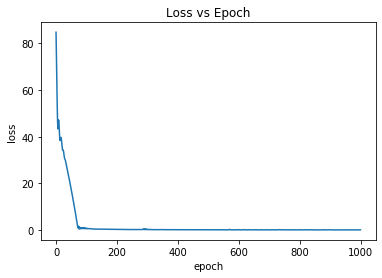

In [10]:
predict = model(X, weights, bias)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=predict, labels=Y))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

init = tf.global_variables_initializer()


with tf.Session() as sess:
    sess.run(init)
    loss = []
    for epoch in range(epochs):
        _, c = sess.run([optimizer, cost], feed_dict = {X: X_train, Y: y_train})
        loss.append(c)
        print("Epoch: {}, Cost: {}".format(epoch, c))
        
    # Testing 
    test_result = sess.run(predict, feed_dict = {X: X_test})
    correct_prediction = tf.equal(tf.argmax(test_result, 1), tf.argmax(y_test, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    
    print(type(correct_prediction))
    print("Accuracy: {}".format(accuracy.eval({X: X_test, Y: y_test})))
    
    plt.plot([i for i in range(epochs)], loss)
    plt.title("Loss vs Epoch")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.show()